In [155]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, LassoCV,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.feature_selection import *
import random
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [121]:
train = pd.read_csv('../../raw/LiChuan/trainallfeatures.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [122]:
# 去掉 2012 年数据, 噪音太多
train = train[train['year']!=2012]

In [123]:
# year 和 month 进行 one-hot 编码
train.drop_duplicates(inplace=True)
labels = train.sale_quantity[:8120]
train = train.drop(['class_id','sale_quantity', 'sale_date'], axis=1)

# train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train['year'], prefix='year')
month_dummies = pd.get_dummies(train['month'], prefix='month')
train = pd.concat([train, year_dummies], axis=1)
train = pd.concat([train, month_dummies], axis=1)
train = train.drop(['year', 'month'], axis=1)
train.fillna(0.0, inplace=True)

test = train[8120:].reset_index(drop=True)
train = train[:8120].reset_index(drop=True)

In [124]:
# 获取 2017-10 作为测试集
test_X = train[-140:]
test_Y = labels[-140:]

# 2012-01 至 2017-10 作为训练集
train_X = train[:-140]
train_Y = labels[:-140]

## 测试模型 Lesso

In [125]:
# LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
lasso.fit(train_X, train_Y)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [126]:
prediction = lasso.predict(test_X)

In [127]:
sp.sqrt(sp.mean((test_Y - prediction) ** 2))

184.38388665648282

## Random forest

In [110]:
RFR = RandomForestRegressor(n_estimators=100)
RFR.fit(train_X, train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [111]:
prediction = RFR.predict(test_X)
sp.sqrt(sp.mean((test_Y - prediction) ** 2))

159.12881650905166

## LightGBM

In [106]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=1100,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=5, min_sum_hessian_in_leaf=11)

In [107]:
model_lgb.fit(train_X, train_Y)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2319, feature_fraction_seed=9,
       learning_rate=0.05, max_bin=55, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=5, min_split_gain=0.0,
       min_sum_hessian_in_leaf=11, n_estimators=1100, n_jobs=-1,
       num_leaves=5, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [108]:
prediction = model_lgb.predict(test_X)
sp.sqrt(sp.mean((test_Y - prediction) ** 2))

128.56357108248002

## ElasticNet

In [135]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

In [136]:
ENet.fit(train_X, train_Y)
prediction = ENet.predict(test_X)
sp.sqrt(sp.mean((test_Y - prediction) ** 2))

184.18218548115155

## GradientBoostingRegressor

In [172]:
GBoost = GradientBoostingRegressor(n_estimators=4800, learning_rate=0.008,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

In [173]:
GBoost.fit(train_X, train_Y)
prediction = GBoost.predict(test_X)
sp.sqrt(sp.mean((test_Y - prediction) ** 2))

127.50954577357335

## XGBoost

In [191]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.1, n_estimators=2000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             random_state=7, nthread=-1)

In [192]:
model_xgb.fit(train_X, train_Y)
prediction = model_xgb.predict(test_X)
sp.sqrt(sp.mean((test_Y - prediction) ** 2))

121.78006586811904

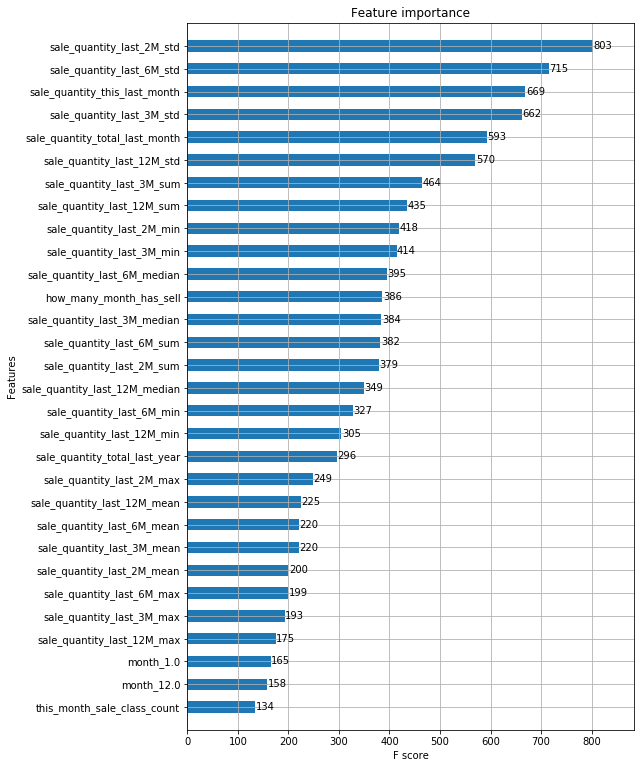

In [211]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model_xgb, max_num_features=30, height=0.5, ax=ax)

## 输出结果

In [195]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=1100,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=5, min_sum_hessian_in_leaf=11)

In [199]:
model_lgb.fit(train, labels)
lgb_prediction = model_lgb.predict(test)

In [214]:
submit['predict_quantity'] = lgb_prediction
submit.to_csv('../../raw/LiChuan/result_20180208_lgb-allfeatures.csv',index=False, header=True)  

In [207]:
lgb_prediction.sum()

50248.19811587374

In [201]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.1, n_estimators=2000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             random_state=7, nthread=-1)

In [202]:
model_xgb.fit(train_X, train_Y)
xgb_prediction = model_xgb.predict(test_X)

In [209]:
xgb_prediction.sum()

54612.219

In [215]:
submit['predict_quantity'] = xgb_prediction
submit.to_csv('../../raw/LiChuan/result_20180208_xgbreg-allfeatures.csv',index=False, header=True)  

In [203]:
GBoost = GradientBoostingRegressor(n_estimators=4800, learning_rate=0.008,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

In [204]:
GBoost.fit(train_X, train_Y)
gb_prediction = GBoost.predict(test_X)

In [206]:
gb_prediction.sum()

52836.366700964936

In [216]:
submit['predict_quantity'] = gb_prediction
submit.to_csv('../../raw/LiChuan/result_20180208_gb-allfeatures.csv',index=False, header=True)  